## Bert

In [25]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import warnings

path = '/kaggle/input/dataset/train.csv'

df = pd.read_csv(path)

# Define features and labels
y = df['score']
x = df.drop('score', axis=1)
x['full_text'] = x['full_text'].apply(lambda x:x.lower())

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(x, y, train_size=0.8, random_state=42, stratify= y)

# Extract features from the training and testing sets
train_texts = train_X['full_text'].tolist()
test_texts = test_X['full_text'].tolist()

# Adjust labels to be zero-indexed
train_labels = torch.tensor(train_y.tolist()) - 1
test_labels = torch.tensor(test_y.tolist()) - 1

# Load the pre-trained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training data
train_inputs = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")

# Tokenize the testing data
test_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

class EssayDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset and dataloader for training data
train_dataset = EssayDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

# Create dataset and dataloader for testing data
test_dataset = EssayDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [28]:
# Load the pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


# Define a function to evaluate the model on validation data
def evaluate_model(model, dataloader, device):
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to GPU if available
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(batch['labels'].tolist())
    accuracy = accuracy_score(true_labels, predictions)
    return val_loss / len(dataloader), accuracy

# Training settings
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3

# To store losses
train_losses = []
val_losses = []
val_accuracies = []

model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    model.train()
    for batch in tqdm(train_dataloader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to GPU if available
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss}")

    # Evaluate the model on validation data
    avg_val_loss, val_accuracy = evaluate_model(model, test_dataloader, device)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss}")
    print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


cuda
Epoch 1/3


Training:   0%|          | 0/3462 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

Epoch 1 Training Loss: 1.0110103079499295


Evaluating:   0%|          | 0/866 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|██████████| 866/866 [01:01<00:00, 14.06it/s]


Epoch 1 Validation Loss: 0.9156559301716626
Epoch 1 Validation Accuracy: 0.597631426920855
Epoch 2/3


Training:   0%|          | 0/3462 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

Epoch 2 Training Loss: 0.8439163354471334


Evaluating:   0%|          | 0/866 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|██████████| 866/866 [01:01<00:00, 14.08it/s]


Epoch 2 Validation Loss: 0.8743116676325611
Epoch 2 Validation Accuracy: 0.6227614095898325
Epoch 3/3


Training:   0%|          | 0/3462 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

Epoch 3 Training Loss: 0.7179266564754617


Evaluating:   0%|          | 0/866 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|██████████| 866/866 [01:01<00:00, 14.09it/s]

Epoch 3 Validation Loss: 0.8947303076694111
Epoch 3 Validation Accuracy: 0.6256499133448874


### Train and Test Plot of Model with 2 epochs 

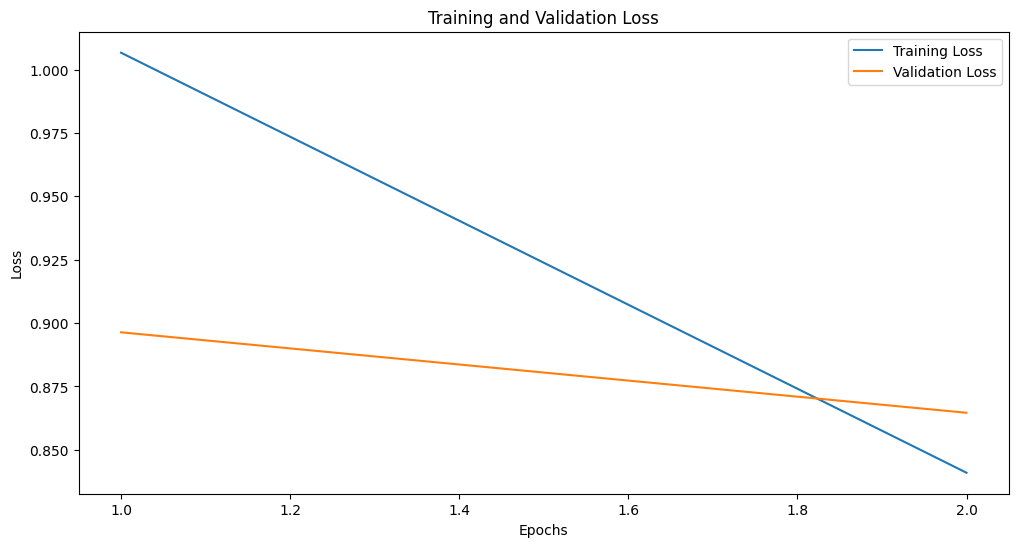

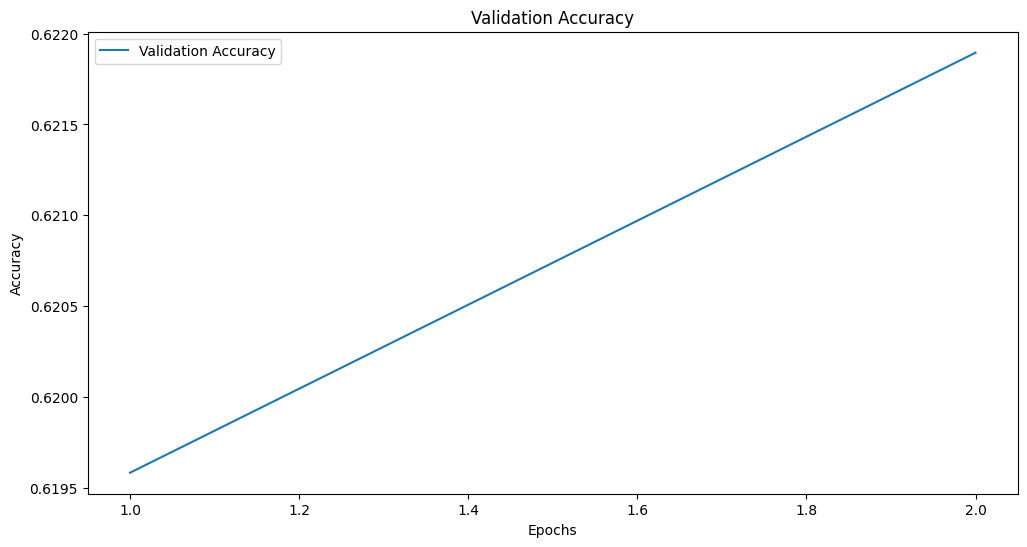

In [27]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

### Train and Test of model with 7 epochs 

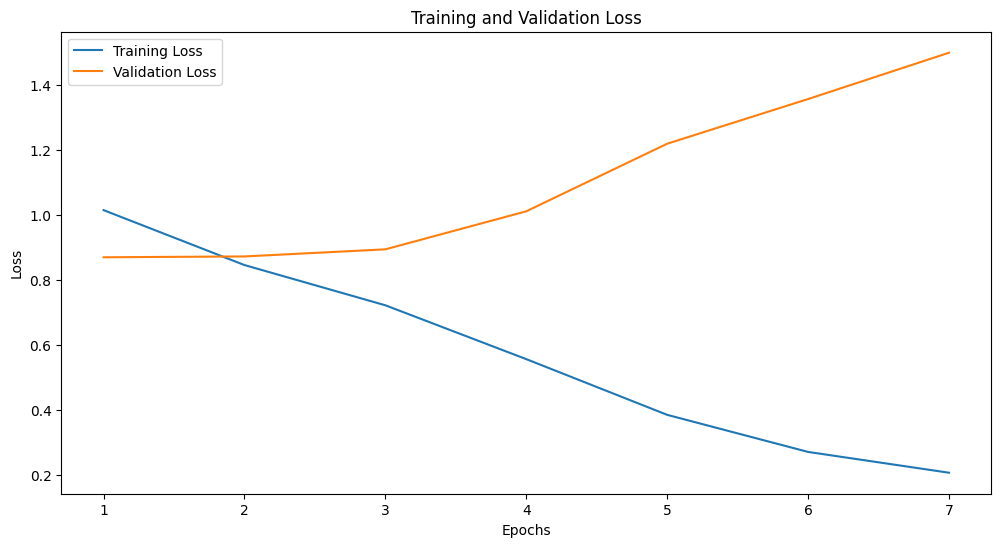

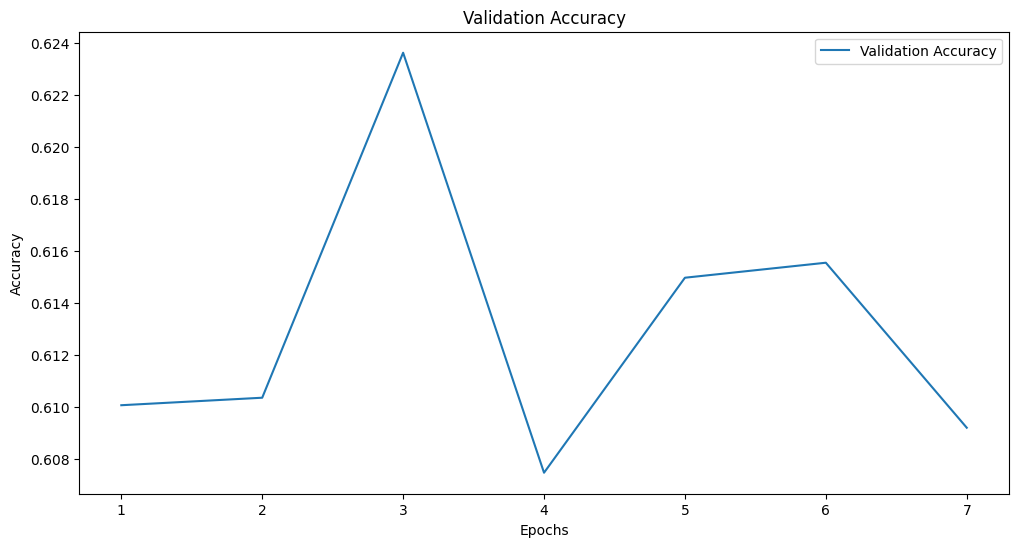

In [5]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

### Logistic Regression on Bert Embedding 

In [5]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [6]:
path = '/kaggle/input/dataset/train.csv'

df = pd.read_csv(path)

# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and encode your text data
def get_bert_embeddings(text_list):
    embeddings = []
    for text in text_list:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
    return np.vstack(embeddings)


In [22]:
# Assuming your DataFrame is named df and the text column is 'text'
df['full_text'] = df['full_text'].apply(lambda x:x.lower())
text_list = df['full_text'].tolist()
X_df = get_bert_embeddings(text_list)

In [23]:
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify= y)

logistic_regression_model =  LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [24]:
# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.5742345465049105
Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.41      0.47       251
           2       0.63      0.63      0.63       945
           3       0.56      0.63      0.59      1256
           4       0.56      0.55      0.55       785
           5       0.48      0.33      0.39       194
           6       0.23      0.10      0.14        31

    accuracy                           0.57      3462
   macro avg       0.50      0.44      0.46      3462
weighted avg       0.57      0.57      0.57      3462



In [17]:
y_pred1 = logistic_regression_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred1)
report = classification_report(y_train, y_pred1)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.6776453593355002
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.55      0.62      1001
           2       0.72      0.70      0.71      3778
           3       0.66      0.71      0.68      5024
           4       0.64      0.69      0.67      3141
           5       0.66      0.46      0.54       776
           6       0.92      0.66      0.77       125

    accuracy                           0.68     13845
   macro avg       0.72      0.63      0.67     13845
weighted avg       0.68      0.68      0.68     13845

